# MSC Geomet - Using Authentication to Access Flow Predictions
## Quick Demo - WMS

This notebook is designed to quickly help users learn about user/password authentication on the Meteorological Service of Canada's (MSC) [GeoMet](https://eccc-msc.github.io/open-data/msc-geomet/readme_en/#msc-geomet "MSC GeoMet Open Documentation") platform, in order to access flow predictions. We can access the flow predictions through the web map service (WMS) and web coverage service (WCS) with Python. If you are unsure of which service to use, a general rule of thumb is that the <b style="color:Orange;">web map service</b> is primarily used to retrieve <b style="color:Orange;">geospatial images</b> and the <b style="color:Violet;">web coverage service</b> is used to retrieve <b style="color:Violet;">raw geospatial data</b>. This tutorial demonstrates examples using the <b style="color:Orange;">web map service</b>. If you are new to these services we recommend later visiting the more comprehensive tutorials in this repository for accessing flow data with the WMS and WCS. 

## Table of Contents

* [What pre-requistes do I need for this tutorial?](#What-pre-requistes-do-I-need-for-this-tutorial?)
* [How do I get to GeoMet? How do I start retrieving data from GeoMet?](#How-do-I-get-to-GeoMet?-How-do-I-start-retrieving-data-from-GeoMet?)
    * [Establish a connection to GeoMet](#Establish-a-connection-to-GeoMet)
    * [Check what data is available](#Check-what-data-is-available)
    * [Making a simple request with WMS](#Making-a-simple-request-with-WMS)


## What pre-requistes do I need for this tutorial?

First, we import all necessary Python libraries.  The libraries needed are standard Python libraries. The library that we'll use to access GeoMet is a third-party library, [OWSLib](https://geopython.github.io/OWSLib/index.html "OWSLib Documentation"), which stands for the Open Geospatial Consortium (OGC) web service.

In [11]:
# data
import warnings
import re
import time
import configparser
from datetime import datetime, timedelta
from IPython.display import Image

# web map services 
from owslib.wms import WebMapService
from owslib.wcs import WebCoverageService
from owslib.wcs import Authentication

To access the flow prediction from the user/password authenticated version of GeoMet, we need credentials. We can use the built-in configparser utility library, which reads a file with the following format:

```
[Login]
Username = your_user_name 
Password = your_password
```

In [12]:
config = configparser.ConfigParser()
config.read_file(open('config.cfg'))

login = config['Login']

## How do I get to GeoMet? How do I start retrieving data from GeoMet?


When we want to get prediction data from GeoMet we will typically follow three steps:

1. Establish a connection with the GeoMet server. GeoMet will send back a response if we connect successfully.
2. Look "under-the-hood" of the GeoMet response to see what data is available* and for what times.
3. Use our GeoMet connection that we made in step 1, to request the data we are interested in.

*Step 2 is slightly different for authenticated data. We will highlight the differences below.

### Establish a connection to GeoMet

In [13]:
# filter warnings or be prepared to see plenty
warnings.filterwarnings('ignore', module='owslib', category=UserWarning)

In [15]:
# connect to the web map service
wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS',
                    version='1.3.0',
                    timeout=300)

### Check what data is available

In [16]:
# let's have a look at the first 20 data layers in the wms contents
for key in list(wms.contents.keys())[0:20]:
    print(key)

Canadian Weather
ALERTS
CURRENT_CONDITIONS
METNOTES
Regional Deterministic Prediction System (RDPS) [10 km]
RDPS - Coupled to Gulf of St. Lawrence (RDPS-CGSL)
CGSL.ETA_ICEC
CGSL.ETA_ICEPRS
CGSL.ETA_ICESTG
CGSL.ETA_ICET
CGSL.ETA_ICETK
CGSL.ETA_UICE
CGSL.ETA_UOGRD
CGSL.ETA_UU
CGSL.ETA_WTMP
RDPS convective fields
RDPS.CONV_KINDEX.PT3H
RDPS.CONV_ML-CAPE
RDPS.CONV_ML-CIN
RDPS.CONV_ML-EL-HGT


This list tells us what the layer names are available, but they aren't very descriptive. Let's print their titles instead.

In [17]:
# let's have a look at the descriptive names
for key in list(wms.contents.keys())[0:20]:
    print(wms[key].title)

Canadian Weather
Weather Alerts [experimental]
Current Conditions
MetNotes
Regional Deterministic Prediction System (RDPS) [10 km]
RDPS - Coupled to Gulf of St. Lawrence (RDPS-CGSL)
CGSL.ETA.ICEC - Ice cover fraction
CGSL.ETA.ICEPRS - Vertically integrated ice internal pressure (or stress) [N/m]
CGSL.ETA.ICESTG - Vertically integrated compressive ice strength [N/m]
CGSL.ETA.ICET - Ice surface temperature [K]
CGSL.ETA.ICETK - Ice thickness [m]
CGSL.ETA.UICE - Ice speed vector [m/s]
CGSL.ETA.UOGRD - Surface ocean current [m/s]
CGSL.ETA.UU - Wind at surface level [m/s]
CGSL.ETA.WTMP - Water temperature [K]
RDPS convective fields
RDPS.CONV - Thunderstorm potential index George K (3 hourly forecast)
RDPS.CONV - CAPE for a parcel representing the mean of a layer [J/kg]
RDPS.CONV - CIN for a parcel representing the mean of a layer [J/kg]
RDPS.CONV - Height of the equilibrium level for a parcel representing the mean of a layer [m AGL]


Password protected data available on GeoMet will not appear in the lists above. The names of the layers are hidden by design. We must know the name of the hidden layer we are interested ahead of time. 

In [18]:
# for this example, let's have a look at DHPS streamflow
layer_name = 'DHPS_1km_RiverDischarge'

In [19]:
# re-establish a connection with GeoMet, this time specifying the layer and providing our "login" credentials
wms_auth = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layer_name}',
                        version='1.3.0',
                        auth=Authentication(username=login['Username'], password=login['Password']),
                        timeout=300)

In [20]:
for key in list(wms_auth.contents.keys()):
    print(key)

Deterministic Hydrological Prediction System (DHPS) [1 km]
DHPS
DHPS_1km_RiverDischarge


### Making a simple request with WMS

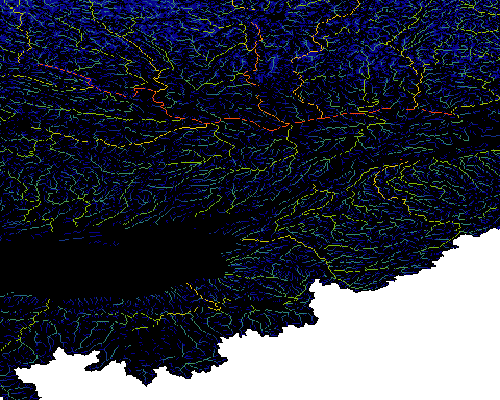

In [21]:
width = 500
height = 400

# example of how to get a map with specific extent covering eastern Ontario / southern Quebec
response = wms_auth.getmap(layers=[layer_name],
                          format='image/png',
                          srs='EPSG:4326',
                          styles=['RiverDischarge'], 
                          bbox=(-78, 42, -74, 47),
                          size=(width, height),
                          transparent=True)

# show image
Image(response.read(), width=width, height=height)